## Import necessary libraries

In [2]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from itertools import combinations
import matplotlib.pyplot as plt  # Import matplotlib
import numpy as np
import os
import csv
import ast
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler,MinMaxScaler, Normalizer, RobustScaler# Import StandardScaler
pd.options.display.max_rows = 3500  # Set to the desired number of rows

#if running on google colab, uncomment the next two lines
#from google.colab import drive
#drive.mount('/content/drive') # Mount Google Drive


## Paths to Data Files
- Data files should be in the same folder as the python code

In [3]:
file_path_man ='FXI_Deficient_Bleeders_NonBleeders_Data.xlsx'
file_path_gidleynoflat = 'Indeterminant_Patient_Data.xlsx'

## Function Definitions
Defines functions to:
- Find the optimal threshold 
- Evaluate the Logisitic Regression Model given coeffiecients and intercept
- Compute Confusion Matrix Metrics

In [4]:
#Finds the optimal threshold that maximizes Youden's J statistic.
def optimal_threshold_youden(y_true, y_scores):
    """
    Finds the optimal threshold that maximizes Youden's J statistic.

    Args:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities or scores.

    Returns:
        float: The optimal threshold.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

#Use found coeffiecients and intercept in logisitic regression model. 
def logistic_regression(coefficients, intercept, df):
    """
    Logistic regression prediction for the given data pulled from a DataFrame
    
    Parameters: 
    coefficients (list): Coefficients for each feature (one value per feature).
    intercept (float): Intercept of the logistic regression model.
    df (pandas.DataFrame): DataFrame containing the input data for which predictions are to be made
    
    Returns:
    np.ndarray: Predicted probabilities for each observation
    """
    
    # Ensure the DataFrame is a numpy array of feature values
    X = df.to_numpy() #Converts DataFrame to a 2D numpy array
    
    # Calculate the linear combination of coefficients and features: X * coefficients + intercept
    linear_combination = np.dot(X,np.array(coefficients)) + intercept
    
    # Apply the logistic (sigmoid) function
    predictions = 1/(1+np.exp(-linear_combination))
    
    return predictions

#Compute confusion matrix and related metrics
def compute_confusion_metrics(y_true, y_scores,threshold):
    """
    Compute confusion matrix (TN, FP, FN, TP) and related metrics (FNR, TPR, TNR, FPR) at a given 
    classification threshold.

    Parameters:
    y_true (array-like): Ground-truth binary labels (0 or 1).
    y_scores (array-like): Predicted probabilities or decision scores.
    threshold (float):Decision threshold for converting scores to binary predictions.

    Returns:
    tuple: (tn, fp, fn, tp, fnr, tpr, tnr, fpr)
    """
    
    prediction = (y_scores >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, prediction).ravel()
        
    fnr = fn/(tp+fn) #false negative rate - proportion of 1's classifed as 0, sensitivity = 1 - fnr 
    tpr = tp/(tp+fn) #true positive rate - proportion of 1's classifed as 1, sensitivity
    
    tnr = tn/(tn+fp) #true negative rate - proportion of 0's classified as 0, specificity = tnr
    fpr = fp/(tn+fp) #false negative rate - proportion of 0's classified as 1, specificity = 1- tnr
    
    
    return tn, fp, fn, tp, fnr, tpr, tnr, fpr


## Load in Datasets and Scale

In [19]:
# 1. Load the data with column titles
# Replace 'your_file.xlsx' with the actual path to your Excel file
data_man = pd.read_excel(file_path_man, header=0)
data_gidleynoflat = pd.read_excel(file_path_gidleynoflat, header=0)  

##################################################
# 2. Separate features and target variable
X_man = data_man.drop(['Phenotype', 'Patient Number'], axis=1) # Drop both phenotype and Patient Number columns
y_man = data_man['Phenotype']
id_man = data_man['Patient Number']

#*****************
X_gidleynoflat = data_gidleynoflat.drop(['Phenotype', 'Patient Number'], axis=1) # Drop both phenotype and Patient Number columns
y_gidleynoflat = data_gidleynoflat['Phenotype']

#*********************
# 3. Scale the features
scaler = MinMaxScaler()
X_man_scaled = scaler.fit_transform(X_man) # Fit and transform on the entire feature set for the manchester data
X_gidleynoflat_scaled = scaler.fit_transform(X_gidleynoflat) # Fit and transform on the entire feature set

# 4. Convert into dataframes
X_man_scaled = pd.DataFrame(X_man_scaled, columns=X_man.columns, index=X_man.index) # Convert X_scaled back to DataFrame
X_gidleynoflat_scaled = pd.DataFrame(X_gidleynoflat_scaled, columns=X_gidleynoflat.columns, index=X_gidleynoflat.index) # Convert X_scaled back to DataFrame

# 5. Split Manchester dataset into partial/severe for sub-analysis
indices_severe = X_man.index[X_man['FXI:C'] < 20].tolist()
indices_partial = X_man.index[X_man['FXI:C'] >= 20].tolist()
X_severe_scaled = X_man_scaled.iloc[indices_severe]
y_severe = y_man.iloc[indices_severe]
X_partial_scaled = X_man_scaled.iloc[indices_partial]
y_partial = y_man.iloc[indices_partial]

## User defines inputs
User defines:
- Fixed features (features that should be included in every model constructed)
- Output file name (default is test.csv if none is given)
- Number of features to be used in model
## Find Model for each combination and analyze
Finds the best logistic regression model for each combination using 5-fold cross-validation.
For each model, 
- Compute 95% Confidence Interval and mean AUROC using bootstrapping
- Compute the optimal threshold used for classification by maximizing the Youden-J statisitc
- Find the Model Area Under Receiver Operating Characteristic Curve (AUROC)
- Compute the confusion matrix: 
    - TP (true positive): Bleeder (1) is classified as Bleeder (1)
    - FN (false negative): Bleeder (1) is classified as Non-Bleeder (0)
    - FP (false positive): Non-Bleeder (0) is classified as Bleeder (1)
    - TN (true negative): Non-Bleeder (0) is classified as Non-Bleeder (0)
- Compute performance rates:
    - TPR (true positive rate): Proportion of Bleeders correctly identified → TP / (TP + FN)
    - FNR (false negative rate): Proportion of Bleeders missed (classified as Non-Bleeders) → FN / (TP + FN)
    - FPR (false positive rate): Proportion of Non-Bleeders incorrectly identified as Bleeders → FP / (TN + FP)
    - TNR (true negative rate): Proportion of Non-Bleeders correctly identified → TN / (TN + FP)

### Outputs:
- Excel File containing results 
- Displays results for the top 5 models (sorted by mean AUROC)
- Plot of the Receiver Operating Character (ROC) curves for the top 5 models (sorted by AUROC) for:
    - Manchester Data
    - Indeterminant Data

Enter the number of fixed features (0, 1 or 2): 2
Enter the name for the output csv file (e.g., my_results.csv): APTT_VWF_PlusOne
Enter the name of fixed feature 1: APTT
Enter the name of fixed feature 2: VWF
Enter the number of additional features to combine: 1
 
Results saved to: Results
 
              combination  AUROC_manchester  mean_AUROC confidence_interval  \
2   [APTT, VWF, SERPIND1]             0.904       0.902     [0.805 - 0.969]   
1      [APTT, VWF, ICAM2]             0.879       0.881     [0.789 - 0.954]   
7      [APTT, VWF, APOC1]             0.878       0.878     [0.796 - 0.947]   
8       [APTT, VWF, SPP2]             0.874       0.875      [0.79 - 0.947]   
10    [APTT, VWF, PLXDC2]             0.871       0.870     [0.765 - 0.956]   

    TrueNeg_manchester  FalsePos_manchester  FalseNeg_manchester  \
2                   35                   11                    1   
1                   36                   10                    3   
7                   38      

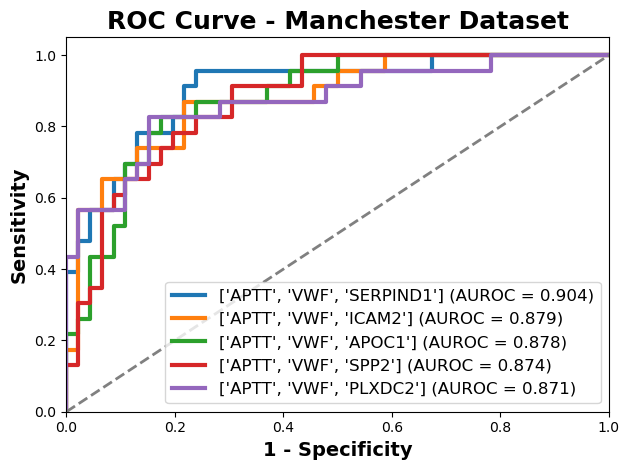

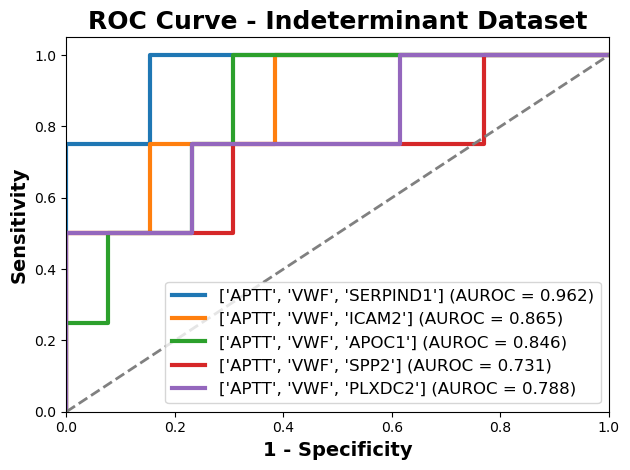

In [20]:
###################################################################
#################### Section for User Inputs ######################
###################################################################

# 1. Get number of fixed features from user input
fixed_features = []
num_fixed_features = int(input("Enter the number of fixed features (0, 1 or 2): "))

# 2. Get output filename from user (will add .csv later if not added here) 
output_file_name = input("Enter the name for the output csv file (e.g., my_results.csv): ") 

#If output_file_name is left empty, test.csv will be used as the output filename
if not output_file_name:
    output_file_name = 'test'
    print('\tNo output file name given. Default filename = test.csv will be used instead.')

#Add .csv extension to output_file_name if it's not already present
if not output_file_name.lower().endswith((".csv")):
    output_file_name += ".csv"

# 3. Generate feature combinations to use in models 
if num_fixed_features == 0: #if there are no fixed features
    protein_combinations = []
    num_additional_features = int(input("Enter the number of features to combine: ")) #get num_additonal_features
    for combination in combinations(X_man.columns, num_additional_features):
        protein_combinations.append(list(combination)) #generate combinations of num_additional_features features 
else: #if user wants fixed features
    for i in range(num_fixed_features):
        feature_name = input(f"Enter the name of fixed feature {i+1}: ")
        fixed_features.append(feature_name)

    # Get number of additional features for combinations
    num_additional_features = int(input("Enter the number of additional features to combine: ")) 

    # Generate combinations with fixed features
    protein_combinations = []
    remaining_features = [col for col in X_man.columns if col not in fixed_features]
    for combination in combinations(remaining_features, num_additional_features):
        protein_combinations.append(fixed_features + list(combination))
        
##########################################################################
###################### End of User Defined Inputs ########################
##########################################################################

##########################################################################
########    Perform logistic regression with cross-validation,    ########
######## get confidence intervals, and calculate AUCs & threshold ########
##########################################################################
results = []

for combination in protein_combinations:
     #select data columns for chosen features
    X_man_subset = X_man_scaled[combination] 
    X_gidleynoflat_subset = X_gidleynoflat_scaled[combination]

    # 1. 5-fold Cross-Validation for Model Selection
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    
    best_model_cv = None  # To store the best model from CV
    best_auc_cv = 0  # To store the best AUC from CV

    for train_index, test_index in cv.split(X_man_subset, y_man):
        X_man_train, X_man_test = X_man_subset.iloc[train_index], X_man_subset.iloc[test_index]
        y_man_train, y_man_test = y_man.iloc[train_index], y_man.iloc[test_index]

        model = LogisticRegression()
        model.fit(X_man_train, y_man_train)
        y_man_pred_proba = model.predict_proba(X_man_test)[:, 1]
        auc_score_man = roc_auc_score(y_man_test, y_man_pred_proba)

        if auc_score_man > best_auc_cv:
            best_auc_cv = auc_score_man
            best_model_cv = model  # Store the best model from this fold
            
    # 2. Bootstrapping for the Best Model from Cross-Validation
    n_bootstraps = 1000
    bootstrap_auc_scores = []
    
    if best_model_cv is not None:  # Check if a best model was found in CV
        for _ in range(n_bootstraps):
            X_boot, y_boot = resample(X_man_subset, y_man, stratify=y_man, replace=True)
            # Use the best model directly (no retraining or subsetting)
            y_pred_proba_boot = best_model_cv.predict_proba(X_boot)[:, 1]
            bootstrap_auc_scores.append(roc_auc_score(y_boot, y_pred_proba_boot))
            
        mean_auc = np.mean(bootstrap_auc_scores)
        confidence_interval = np.percentile(bootstrap_auc_scores, [2.5, 97.5]) #95% CI
        saving_CI = f"[{round(confidence_interval[0],3)} - {round(confidence_interval[1],3)}]" #write it to be stored in results

        # 3. Apply Best Model to the Datasets and Calculate Results
        y_man_pred_proba = best_model_cv.predict_proba(X_man_scaled[combination])[:, 1]
        y_gidleynoflat_pred_proba = best_model_cv.predict_proba(X_gidleynoflat_scaled[combination])[:, 1] 
        
        y_severe_pred_proba = best_model_cv.predict_proba(X_severe_scaled[combination])[:, 1] 
        y_partial_pred_proba = best_model_cv.predict_proba(X_partial_scaled[combination])[:, 1] 
        
        #Calculate AUC for each
        auc_man = roc_auc_score(y_man, y_man_pred_proba)
        auc_gidleynoflat = roc_auc_score(y_gidleynoflat, y_gidleynoflat_pred_proba)
        
        auc_severe = roc_auc_score(y_severe, y_severe_pred_proba)
        auc_partial = roc_auc_score(y_partial, y_partial_pred_proba)
        
        #Find optimal threshold by optimizing youden-j statistic
        youden_threshold = optimal_threshold_youden(y_man, y_man_pred_proba)
        
        #Calculate confusion matrix (TP,TN, FP, FN), FNR, TPR, TNR, FPR
        tn_man, fp_man, fn_man, tp_man, fnr_man, tpr_man, tnr_man, fpr_man = compute_confusion_metrics(y_man, y_man_pred_proba,youden_threshold)
        tn_gidleynoflat, fp_gidleynoflat, fn_gidleynoflat, tp_gidleynoflat, fnr_gidleynoflat, tpr_gidleynoflat, tnr_gidleynoflat, fpr_gidleynoflat = compute_confusion_metrics(y_gidleynoflat, y_gidleynoflat_pred_proba,youden_threshold)

        # 4. Store the Results
        results.append({
            'combination': combination,
            #Results from Manchester Dataset
            'AUROC_manchester': round(auc_man,3), #Auc for full Manchester dataset
            'mean_AUROC': round(mean_auc,3), #Mean auc for Manchester dataset calcualted during bootstrapping
            'confidence_interval': saving_CI, #95% confidence_interval,
            'TrueNeg_manchester': tn_man,
            'FalsePos_manchester': fp_man,
            'FalseNeg_manchester': fn_man,
            'TruePos_manchester': tp_man,
#             'FNR_manchester': round(fnr_man,3),
            'Sensitivity_manchester': round(tpr_man,3),
            'Specificity_manchester': round(tnr_man,3),
#             'FPR_manchester': round(fpr_man,3),
            #Results of partial/severe sub-analysis
            'AUROC_partial': round(auc_partial,3),
            'AUROC_severe': round(auc_severe,3),
            #Results from Indeterminant (Gidley_noflat) dataset
            'AUROC_gidleynoflat': round(auc_gidleynoflat,3), 
            'TrueNeg_gidleynoflat': tn_gidleynoflat,
            'FalsePos_gidleynoflat': fp_gidleynoflat,
            'FalseNeg_gidleynoflat': fn_gidleynoflat,
            'TruePos_gidleynoflat': tp_gidleynoflat,
#             'FNR_gidleynoflat': round(fnr_gidleynoflat,3),
#             'TPR_gidleynoflat': round(tpr_gidleynoflat,3),
#             'TNR_gidleynoflat': round(tnr_gidleynoflat,3),
#             'FPR_gidleynoflat': round(fpr_gidleynoflat.3),
            #Model Information
            'best_model_cv': best_model_cv,  #Store the best model from CV
            'model_intercept': best_model_cv.intercept_[0],  #Intercept from best CV model
            'model_coefficients': best_model_cv.coef_.tolist(),  #Coefficients from best CV model
            'optimal_thresh': youden_threshold #Optimal threshold
        })

# 5. Reformat and Save Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['mean_AUROC'], ascending=False) #sort by the mean_auc
# results_df.head(5)

save_folder = 'Results'

results_df.to_csv(os.path.join(save_folder, output_file_name), index=False)

print(' ')
print(f"Results saved to: {save_folder}")
print(' ')

# 6. Plot ROC curves for top 10
pd.set_option('display.max_columns', None)  # Show all columns
top_5_results = results_df.head(5)
print(top_5_results)
for index, row in top_5_results.iterrows():
    combination = row['combination']
    X_man_subset = X_man_scaled[combination]

    # Create LogisticRegression model with default parameters
    best_model = row['best_model_cv']  # Get the best model from CV
    roc_auc  = row['AUROC_manchester']
    y_man_pred_proba = best_model.predict_proba(X_man_scaled[combination])[:, 1]
    fpr, tpr, _ = roc_curve(y_man, y_man_pred_proba)  # Calculate ROC curve
    plt.plot(fpr, tpr,lw=3,label=f'{combination} (AUROC = {roc_auc:.3f})')  # Plot ROC curve
    
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=14, fontweight='bold')
plt.ylabel('Sensitivity', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.title("ROC Curve - Manchester Dataset", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

for index, row in top_5_results.iterrows():
    combination = row['combination']
    X_gidleynoflat_subset = X_gidleynoflat_scaled[combination]

    # Create LogisticRegression model with default parameters
    best_model = row['best_model_cv']  # Get the best model from CV
    roc_auc  = row['AUROC_gidleynoflat']
    y_gidleynoflat_pred_proba = best_model.predict_proba(X_gidleynoflat_scaled[combination])[:, 1]
    fpr, tpr, _ = roc_curve(y_gidleynoflat, y_gidleynoflat_pred_proba)  # Calculate ROC curve
    plt.plot(fpr, tpr,lw=3,label=f'{combination} (AUROC = {roc_auc:.3f})')  # Plot ROC curve
    
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=14, fontweight='bold')
plt.ylabel('Sensitivity', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.title("ROC Curve - Indeterminant Dataset", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()
      

### Optinial: Code to generate Probabilities

In [ ]:
def get_probabilties(X_data_scaled, y_true, model_df):
     """
    Compute predicted probabilities for multiple logistic regression models.

    For each model in `model_df`, selects the feature subset, applies the
    model coefficients and intercept, and calculates probabilities for all
    samples. Returns a DataFrame with true labels and predicted probabilities
    for each feature combination.
    
    Parameters:
    X_data_scaled (pandas.DataFrame): Scaled feature data for all samples.
    y_true (array-like): True labels for the samples (used as reference in the results DataFrame).
    model_df (pandas.DataFrame): DataFrame containing model specifications with columns:
        - 'combination': list of feature names used in the model
        - 'model_intercept': intercept term
        - 'model_coefficients': coefficients for each feature

    Returns:
    pandas.DataFrame
        DataFrame containing:
        - 'Phenotype' column with true labels
        - One column per feature combination with predicted probabilities
    """
    
    results_prob = pd.DataFrame({'Phenotype': y_true})
    for index,row in model_df.iterrows():
        comb = ast.literal_eval(row['combination'])
        X_data_subset = X_data_scaled[comb]
#         row_index = results_df.index[results_df['combination'] == str(comb)].tolist()
#         row_index = row_index[0]
        intercept = model_df['model_intercept'][index]
        coeff = model_df['model_coefficients'][index]
        coeff = ast.literal_eval(coeff)[0]
        y_proba = logistic_regression(coeff, intercept, X_data_subset)
        results_prob[str(comb)] = y_proba
    
    return results_prob